# Detection of Red Blood Cells

In [1]:
from BloodDataset import BloodDataset
import utils
import torch

import numpy as np
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from util.engine import train_one_epoch

from  util import transforms as T

import matplotlib.pyplot as plt
from PIL import Image

## - Function for draw boxes in blood cells

In [2]:
def showBoxes(img, boxes, path = 'img.png'):

    fig, ax = plt.subplots(figsize=(18,10))
    ax.axis('off')
    plt.imshow(img)
    for box in boxes:
        x1 = box[0]
        y1 = box[1]
        x2 = box[2]
        y2 = box[3]
        ax.plot([x1,x2], [y1,y1], c='red', linewidth=4)
        ax.plot([x1,x1], [y1,y2], c='red', linewidth=4)
        ax.plot([x1,x2], [y2,y2], c='red', linewidth=4)
        ax.plot([x2,x2], [y1,y2], c='red', linewidth=4)

## - Change model topology

In [3]:
def get_model_instance(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained = True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

## - Transform function (Pytorch utility)

In [4]:
def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

## - Set device to Cuda

In [5]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

## - Number of classes (RBC, WBC, Plaquetes)

In [6]:
num_classes = 3

## - Get dataset

In [7]:
dataset = BloodDataset(get_transform(train = False), _type = 'train')
dataset = torch.utils.data.Subset(dataset, np.arange(len(dataset)))
data_loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=4, collate_fn=utils.collate_fn)

## - Create model

In [8]:
model = get_model_instance(num_classes)

## - Move model to Cuda Device

In [9]:
model = model.to(device)

## - Set parameters for training

In [10]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay= 0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
num_epochs = 10

## - Train the model

In [11]:
for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    lr_scheduler.step()

Epoch: [0]  [  0/299]  eta: 0:03:40  lr: 0.000022  loss: 2.1156 (2.1156)  loss_classifier: 0.8535 (0.8535)  loss_box_reg: 0.5678 (0.5678)  loss_objectness: 0.5913 (0.5913)  loss_rpn_box_reg: 0.1030 (0.1030)  time: 0.7367  data: 0.0783  max mem: 1187
Epoch: [0]  [ 10/299]  eta: 0:00:59  lr: 0.000189  loss: 1.4956 (1.6860)  loss_classifier: 0.7934 (0.7627)  loss_box_reg: 0.5547 (0.5515)  loss_objectness: 0.1018 (0.2531)  loss_rpn_box_reg: 0.1011 (0.1187)  time: 0.2047  data: 0.0086  max mem: 1450
Epoch: [0]  [ 20/299]  eta: 0:00:49  lr: 0.000357  loss: 1.2815 (1.4059)  loss_classifier: 0.6040 (0.6512)  loss_box_reg: 0.5237 (0.4985)  loss_objectness: 0.0587 (0.1555)  loss_rpn_box_reg: 0.0889 (0.1007)  time: 0.1503  data: 0.0016  max mem: 1450
Epoch: [0]  [ 30/299]  eta: 0:00:45  lr: 0.000525  loss: 0.9251 (1.2171)  loss_classifier: 0.4283 (0.5574)  loss_box_reg: 0.3963 (0.4445)  loss_objectness: 0.0466 (0.1266)  loss_rpn_box_reg: 0.0735 (0.0887)  time: 0.1489  data: 0.0016  max mem: 1450


## - Show results in Testing data examples

In [12]:
model = model.eval()

In [13]:
transforms = []
transforms.append(T.ToTensor())
t = T.Compose(transforms)

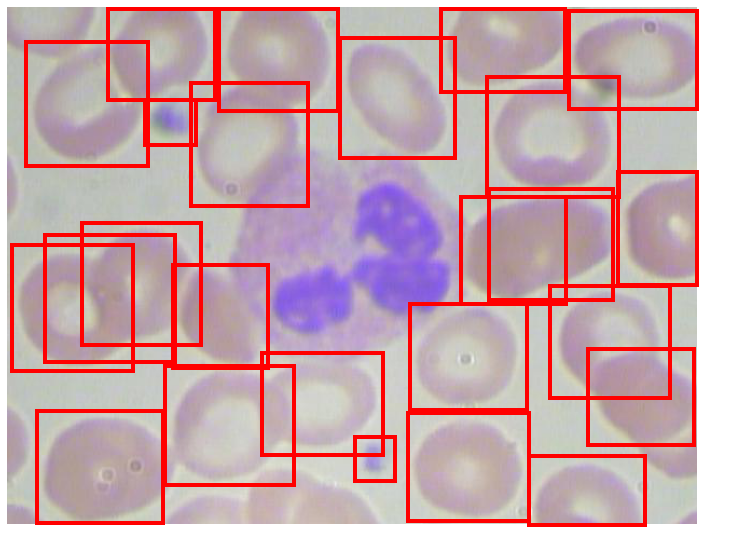

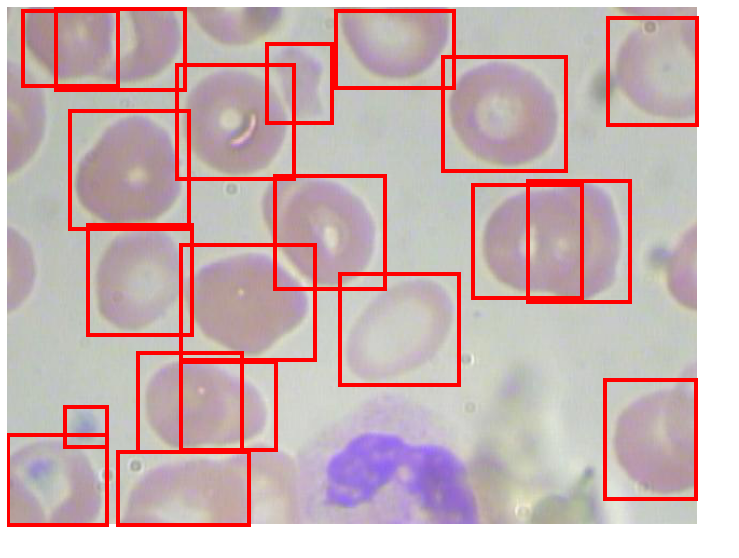

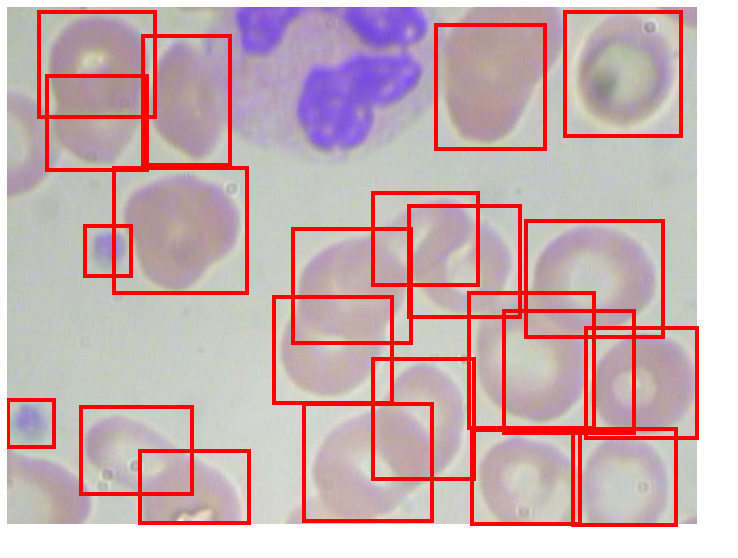

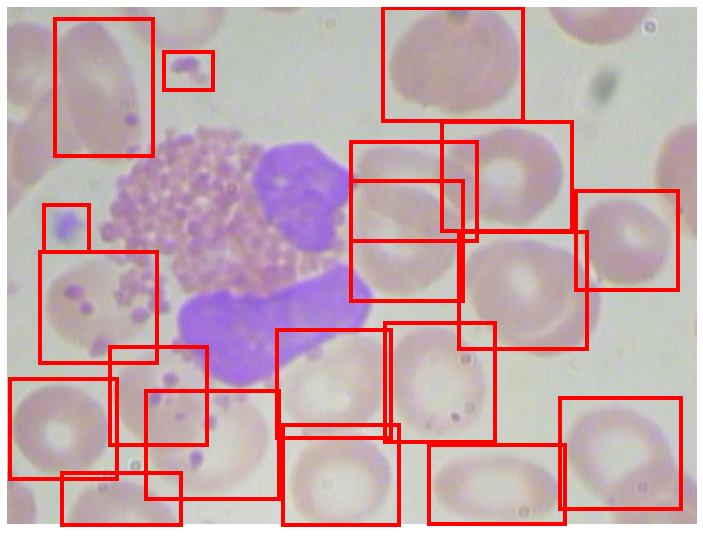

In [14]:
img1 = Image.open('../CBC/Testing/Images/BloodImage_00339.jpg')
img2 = Image.open('../CBC/Testing/Images/BloodImage_00340.jpg')
img3 = Image.open('../CBC/Testing/Images/BloodImage_00343.jpg')
img4 = Image.open('../CBC/Testing/Images/BloodImage_00344.jpg')

imgs = [img1, img2, img3, img4]
names = ['img1', 'img2', 'img3', 'img4']

for i, orig in enumerate(imgs):
    img, tar = t(orig, {})
    img = img.to(device)
    model = model.eval()
    results = model([img])
    boxes = results[0]['boxes'].cpu().detach().numpy()
    accs = results[0]['scores'].cpu().detach().numpy()
    showBoxes(np.array(orig), boxes[accs > 0.10])
    plt.show()